# CTRL - Function Approximation Tutorial: Continuous state Fitted Q Iteration (FQI) with Linear Regression with polynomial features

Website: https://control-rl.github.io/

Gymnasium documentation: https://gymnasium.farama.org/

This notebook is adapted from the open-source tutorial of Antonin Raffin done at RLSS2023. The original tutorial can be found [here](https://github.com/araffin/rlss23-dqn-tutorial)

## Introduction

In this notebook, you will implement the Fitted Q Iteration (FQI) algorithm to solve the [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) problem.

This notebooks will first cover the basics for using the Gymnasium library: how to instantiate an environment, step into it and collect training data from the FQI algorithm.

You will then learn how to implement step-by-step the FQI algorithm which is the predecessor of the [Deep Q-Network (DQN)](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) algorithm.

## Install Dependencies

In [ ]:
!pip install git+https://github.com/Control-RL/Function-Approximation --upgrade

In [ ]:
!apt-get install ffmpeg  # For visualization

## First steps with the Gym interface

An environment that follows the [gym interface](https://gymnasium.farama.org/) is quite simple to use.
It provides to this user mainly three methods, which have the following signature (for gym versions > 0.26):

- `reset()` called at the beginning of an episode, it returns an observation and a dictionary with additional info (defaults to an empty dict)
- `step(action)` called to take an action with the environment, it returns the next observation, the immediate reward, whether new state is a terminal state (episode is finished), whether the max number of timesteps is reached (episode is artificially finished), and additional information
- (Optional) `render()` which allow to visualize the agent in action. Note that graphical interface does not work on google colab, so we cannot use it directly (we have to rely on `render_mode='rbg_array'` to retrieve an image of the scene).

Under the hood, it also contains two useful properties:
- `observation_space` which one of the gym spaces (`Discrete`, `Box`, ...) and describe the type and shape of the observation
- `action_space` which is also a gym space object that describes the action space, so the type of action that can be taken

The best way to learn about [gym spaces](https://gymnasium.farama.org/api/spaces/) is to look at the [source code](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/spaces), but you need to know at least the main ones:
- `gym.spaces.Box`: A (possibly unbounded) box in $R^n$. Specifically, a Box represents the Cartesian product of n closed intervals. Each interval has the form of one of [a, b], (-oo, b], [a, oo), or (-oo, oo). Example: A 1D-Vector or an image observation can be described with the Box space.
```python
# Example for using image as input:
observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
```                                       

- `gym.spaces.Discrete`: A discrete space in $\{ 0, 1, \dots, n-1 \}$
  Example: if you have two actions ("left" and "right") you can represent your action space using `Discrete(2)`, the first action will be 0 and the second 1.

## CartPole Environment

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gymnasium.farama.org/environments/classic_control/cart_pole/](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)

In [1]:
import gymnasium as gym

# Instantiate the environment
env = gym.make("CartPole-v1")

In [2]:
# Box(4,) means that it is a Vector with 4 components
print("Observation space:", env.observation_space)
print("Shape:", env.observation_space.shape)
# Discrete(2) means that there is two discrete actions
print("Action space:", env.action_space)

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Shape: (4,)
Action space: Discrete(2)


In [3]:
# The reset method is called at the beginning of an episode
obs, info = env.reset()

In [4]:
# Sample a random action
action = env.action_space.sample()
print(f"Sampled action: {action}")

Sampled action: 1


In [5]:
# step in the environment
obs, reward, terminated, truncated, info = env.step(action)

In [6]:
# Note the obs is a numpy array
# info is an empty dict for now but can contain any debugging info
# reward is a scalar
print(obs.shape, reward, terminated, truncated, info)

(4,) 1.0 False False {}


### Exercise (10 minutes): write the function to collect data

This function collects an offline dataset of transitions that will be used to train a model using the FQI algorithm.

See docstring of the function for what is expected as input/output.

In [7]:
from dataclasses import dataclass

import numpy as np
from gymnasium import spaces


@dataclass
class OfflineData:
    """
    A class to store transitions.
    """

    observations: np.ndarray  # same as "state" in the theory
    next_observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    terminateds: np.ndarray

In [9]:
def collect_data(env_id: str, n_steps: int = 50_000) -> OfflineData:
    """
    Collect transitions using a random agent (sample action randomly).

    :param env_id: The name of the environment.
    :param n_steps: Number of steps to perform in the env.
    :return: The collected transitions.
    """
    # Create the Gym env
    env = gym.make(env_id)

    assert isinstance(env.observation_space, spaces.Box)
    # Numpy arrays (buffers) to collect the data
    observations = np.zeros((n_steps, *env.observation_space.shape))
    next_observations = np.zeros((n_steps, *env.observation_space.shape))
    # Discrete actions
    actions = np.zeros((n_steps, 1))
    rewards = np.zeros((n_steps,))
    terminateds = np.zeros((n_steps,))

    # Variable to know if the episode is over (done = terminated or truncated)
    done = False
    # Start the first episode
    obs, _ = env.reset()

    ### YOUR CODE HERE
    # You need to collect transitions for `n_steps` using
    # a random agent (sample action uniformly).
    # Do not forget to reset the environment if the current episode is over
    # (done = terminated or truncated)
    #
    # TODO:
    # 1. Sample a random action
    # 2. Step in the env using this random action
    # 3. Retrieve the new transition data (observation, reward, ...)
    #  and update the numpy arrays (buffers)
    # 4. Repeat until you collected `n_steps` transitions

    for idx in range(n_steps):
        # Sample a random action
        action = env.action_space.sample()
        # Step in the environment
        next_obs, reward, terminated, truncated, info_ = env.step(action)

        # Store the transition
        # Note: we only record true termination (timeouts/truncations are artificial terminations)
        observations[idx, :] = obs
        next_observations[idx, :] = next_obs
        actions[idx, :] = action
        rewards[idx] = reward
        terminateds[idx] = terminated
        # Update current observation
        obs = next_obs
        # Check if the episode is over
        done = terminated or truncated

        # Don't forget to reset the env at the end of an episode
        if done:
            obs, _ = env.reset()

    ### END OF YOUR CODE

    return OfflineData(
        observations,
        next_observations,
        actions,
        rewards,
        terminateds,
    )

Let's try the collect data method:

In [10]:
env_id = "CartPole-v1"
n_steps = 50_000
# Collect transitions for n_steps
data = collect_data(env_id=env_id, n_steps=n_steps)

In [11]:
# Check the length of the collected data
assert len(data.observations) == n_steps
assert len(data.actions) == n_steps
# Check that there are multiple episodes in the data
assert not np.all(data.terminateds)
assert np.any(data.terminateds)
# Check the shape of the collected data
if env_id == "CartPole-v1":
    assert data.observations.shape == (n_steps, 4)
    assert data.next_observations.shape == (n_steps, 4)
assert data.actions.shape == (n_steps, 1)
assert data.rewards.shape == (n_steps,)

In [12]:
from pathlib import Path

from dqn_tutorial.fqi import save_data

output_filename = Path("../data") / f"{env_id}_data_continuous"
# Create folder if it doesn't exist
output_filename.parent.mkdir(parents=True, exist_ok=True)

# Save collected data using numpy
save_data(data, output_filename)

Saving to ../data/CartPole-v1_data_continuous.npz


## Fitted Q Iteration (FQI) Algorithm


<div>
    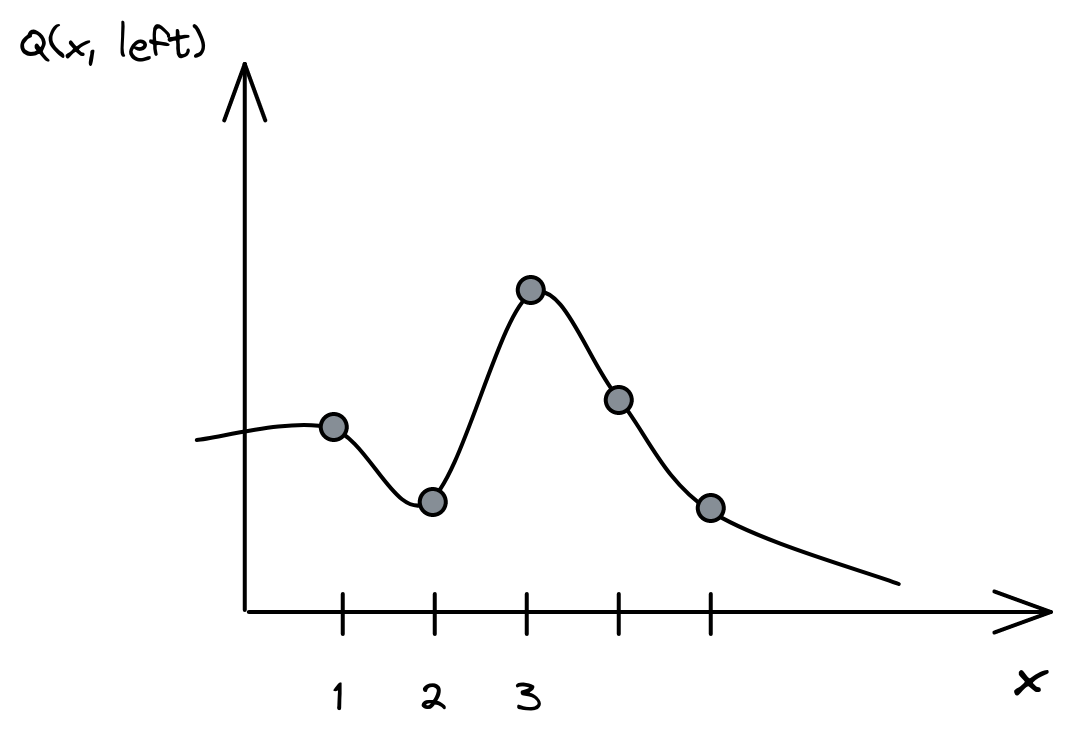
</div>

In [13]:
from functools import partial
from pathlib import Path
from typing import Optional

import gymnasium as gym
import numpy as np
from gymnasium import spaces
from sklearn import tree
from sklearn.base import RegressorMixin
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Choosing a Model

With FQI, you can use any regression model.

Here we are choosing a [k-nearest neighbors regressor](https://scikit-learn.org/stable/modules/neighbors.html#regression), but one could choose a linear model, a decision tree, a neural network, ...

In [14]:
# First choose the regressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def model_class():
    return make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False), 
        LinearRegression()
    )

model = model_class()

### Loading offline dataset

In [15]:
from dqn_tutorial.fqi import load_data

env_id = "CartPole-v1"
output_filename = Path("../data") / f"{env_id}_data_continuous.npz"
render_mode = "rgb_array"

# Create test environment
env = gym.make(env_id, render_mode=render_mode)

# Load saved transitions
data = load_data(output_filename)

### First Iteration

For $n = 0$, the initial training set is defined as:

- $x = (s_t, a_t)$
- $y = r_t$

We fit a regression model $f_\theta(x) = y$ to obtain $ Q^{n=0}_\theta(s, a) $

In [16]:
# First iteration:
# The target q-value is the reward obtained
targets = data.rewards.copy()
# Create input for current observations and actions
# Concatenate the observations and actions
# so we can predict qf(s_t, a_t)
current_obs_input = np.concatenate((data.observations, data.actions), axis=1)
# Fit the estimator for the current target
model = model_class().fit(current_obs_input, targets)
print(f"Score: {model.score(current_obs_input, targets):.2f}")

Score: 1.00


### 1. Exercise (10 minutes): write the function to predict Q-Values


<div>
    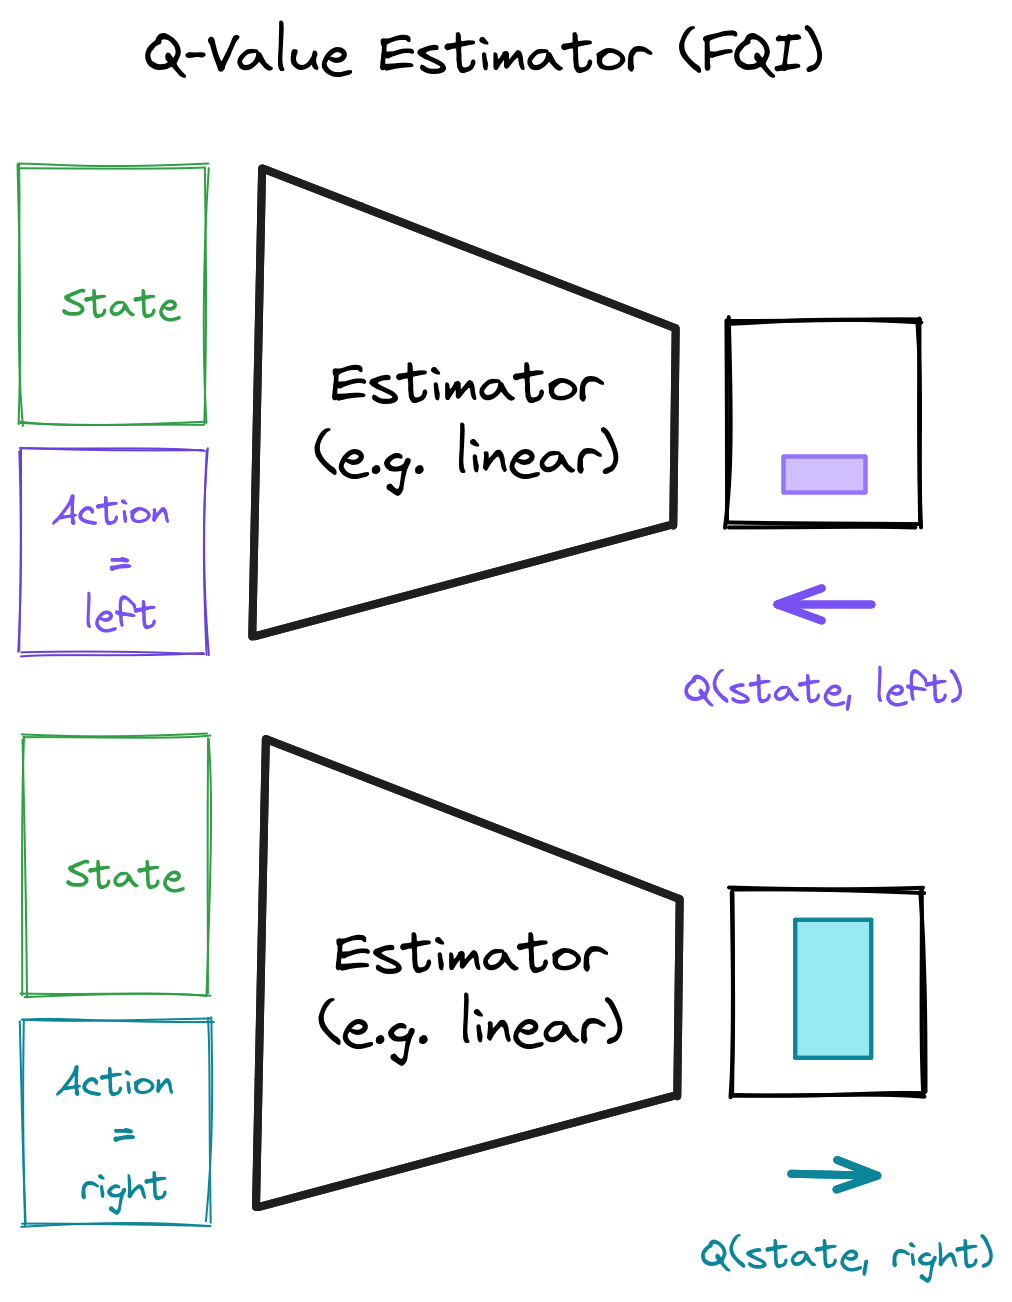
</div>

In [17]:
def get_q_values(
    model: RegressorMixin,
    obs: np.ndarray,
    n_actions: int,
) -> np.ndarray:
    """
    Retrieve the q-values for a set of observations.
    qf(q_t, action) for all possible actions.

    :param model: Q-value estimator
    :param obs: A batch of observations
    :param n_actions: Number of discrete actions.
    :return: The predicted q-values for the given observations
        (batch_size, n_actions)
    """
    batch_size = len(obs)
    q_values = np.zeros((batch_size, n_actions))

    ### YOUR CODE HERE
    # TODO: for every possible actions a:
    # 1. Create the regression model input $(s, a)$ for the action a
    # and states s (here a batch of observations)
    # 2. Predict the q-values for the batch of states
    # 3. Update q-values array for the current action a

    # Predict q-value for each action
    for action_idx in range(n_actions):
        # Note: we should do one hot encoding if not using CartPole (n_actions > 2)
        # Create a vector of size (batch_size, 1) for the current action
        # This allows to do batch prediction for all the provided observations
        actions = action_idx * np.ones((batch_size, 1))
        # Concatenate the observations and the actions to obtain
        # the input to the q-value estimator
        # you can use `np.concatenate()`
        model_input = np.concatenate((obs, actions), axis=1)
        # Predict q-values for the given observation/action combination
        # shape: (batch_size, 1)
        predicted_q_values = model.predict(model_input)
        # Update the q-values array for the current action
        q_values[:, action_idx] = predicted_q_values

    ### END OF YOUR CODE

    return q_values

Let's test it with a subset of the collected data:

In [18]:
n_observations = 2
n_actions = int(env.action_space.n)

q_values = get_q_values(model, data.observations[:n_observations], n_actions)

assert q_values.shape == (n_observations, n_actions)

### 2. Exercise (5 minutes): write the function to evaluate a model

A greedy policy $\pi(s)$ can be defined using the q-value:

$\pi(s) = argmax_{a \in A} Q(s, a)$.

It is the policy that take the action with the highest q-value for a given state.

In [19]:
import os

from gymnasium.wrappers import RecordVideo


def evaluate(
    model: RegressorMixin,
    env: gym.Env,
    n_eval_episodes: int = 10,
    video_name: Optional[str] = None,
) -> None:
    episode_returns, episode_reward = [], 0.0
    total_episodes = 0
    done = False

    # Setup video recorder
    video_recorder = None
    if video_name is not None and env.render_mode == "rgb_array":
        os.makedirs("../logs/videos/", exist_ok=True)

        # New gym recorder always wants to cut video into episodes,
        # set video length big enough but not to inf (will cut into episodes)
        env = RecordVideo(env, "../logs/videos", step_trigger=lambda _: False, video_length=100_000)
        env.start_recording(video_name)

    obs, _ = env.reset()
    n_actions = int(env.action_space.n)
    assert isinstance(env.action_space, spaces.Discrete), "FQI only support discrete actions"

    while total_episodes < n_eval_episodes:

        ### YOUR CODE HERE

        # Retrieve the q-values for the current observation
        # you need to re-use `get_q_values()`
        # Note: you need to add a batch dimension to the observation
        # you can use `obs[np.newaxis, ...]` for that: (obs_dim,) -> (batch_size=1, obs_dim)
        q_values = get_q_values(
            model,
            obs[np.newaxis, ...],
            n_actions,
        )
        # Select the action that maximizes the q-value for each state
        # Don't forget to remove the batch dimension, you can `.item()` for that
        best_action = int(np.argmax(q_values, axis=1).item())

        # Send the action to the env
        obs, reward, terminated, truncated, _ = env.step(best_action)

        ### END OF YOUR CODE

        episode_reward += float(reward)

        done = terminated or truncated
        if done:
            episode_returns.append(episode_reward)
            episode_reward = 0.0
            total_episodes += 1
            obs, _ = env.reset()

    if isinstance(env, RecordVideo):
        print(f"Saving video to ../logs/videos/{video_name}")
        env.close()

    print(f"Total reward = {np.mean(episode_returns):.2f} +/- {np.std(episode_returns):.2f}")

In [20]:
# Evaluate the first iteration
evaluate(model, env, n_eval_episodes=10)
print(f"Score: {model.score(current_obs_input, targets):.2f}")

Total reward = 9.20 +/- 1.08
Score: 1.00


### 3. Exercise (15 minutes): the fitted Q iterations

1. Create the training set based on the previous iteration $ Q^{n-1}_\theta(s, a) $ and the transitions:
- input: $x = (s_t, a_t)$
- if $s_{t+1}$ is non-terminal: $y = r_t + \gamma \cdot \max_{a' \in A}(Q^{n-1}_\theta(s_{t+1}, a'))$
- if $s_{t+1}$ is terminal, do not bootstrap: $y = r_t$

2. Fit a model $f_\theta$ using a regression algorithm to obtain $ Q^{n}_\theta(s, a)$
 
\begin{aligned}
 f_\theta(x) = y
\end{aligned}

4. Repeat, $n = n + 1$

First, let's define some constants:

In [21]:
# Max number of iterations
n_iterations = 20
# How often do we evaluate the learned model
eval_freq = 2
# How many episodes to evaluate every eval-freq
n_eval_episodes = 10
# discount factor
gamma = 0.99
# Number of discrete actions
n_actions = int(env.action_space.n)

Then do several iteration of the FQI algorithm

In [22]:
for iter_idx in range(n_iterations):
    ### YOUR CODE HERE
    # TODO:
    # 1. Compute the q values for the next states using
    # the previous regression model
    # 2. Keep only the next q values that correspond
    # to the greedy-policy
    # 3. Construct the regression target (TD(0) target)
    # 4. Fit a new regression model with this new target

    # Construct TD(0) target
    # using current model and the next observations
    
    # First, retrieve the q-values for the next states
    # for all possible actions
    # you need to use `get_q_values()` method
    next_q_values = get_q_values(
        model,
        data.next_observations,
        n_actions=n_actions,
    )
    # Follow-greedy policy: use the action with the highest q-value
    # to compute the next q-values
    next_q_values = next_q_values.max(axis=1)
    # The new target is the reward + what our agent expect to get
    # if it follows a greedy policy (follow action with the highest q-value)
    # Reminder: you should not bootstrap if terminated=True
    # (you can mask the next q values for that using `np.logical_not`)
    should_bootstrap = np.logical_not(data.terminateds) # (1 - data.terminateds)
    targets = data.rewards + gamma * should_bootstrap * next_q_values
    # Update the q-value estimate with the current target,
    # i.e., fit a regression model using the new target
    model = model_class().fit(current_obs_input, targets)

    ### END OF YOUR CODE

    if (iter_idx + 1) % eval_freq == 0:
        print(f"Iter {iter_idx + 1}")
        print(f"Score: {model.score(current_obs_input, targets):.2f}")
        evaluate(model, env, n_eval_episodes)

Iter 2
Score: 0.68
Total reward = 18.80 +/- 5.74
Iter 4
Score: 0.91
Total reward = 131.40 +/- 39.39
Iter 6
Score: 0.95
Total reward = 236.80 +/- 41.44
Iter 8
Score: 0.96
Total reward = 293.20 +/- 60.25
Iter 10
Score: 0.96
Total reward = 259.60 +/- 34.07
Iter 12
Score: 0.96
Total reward = 304.30 +/- 71.77
Iter 14
Score: 0.96
Total reward = 332.80 +/- 107.43
Iter 16
Score: 0.96
Total reward = 348.30 +/- 79.76
Iter 18
Score: 0.95
Total reward = 326.50 +/- 86.27
Iter 20
Score: 0.95
Total reward = 341.20 +/- 69.97


# add plots of reward and score

#### Analysis of the features the FQI algorithm

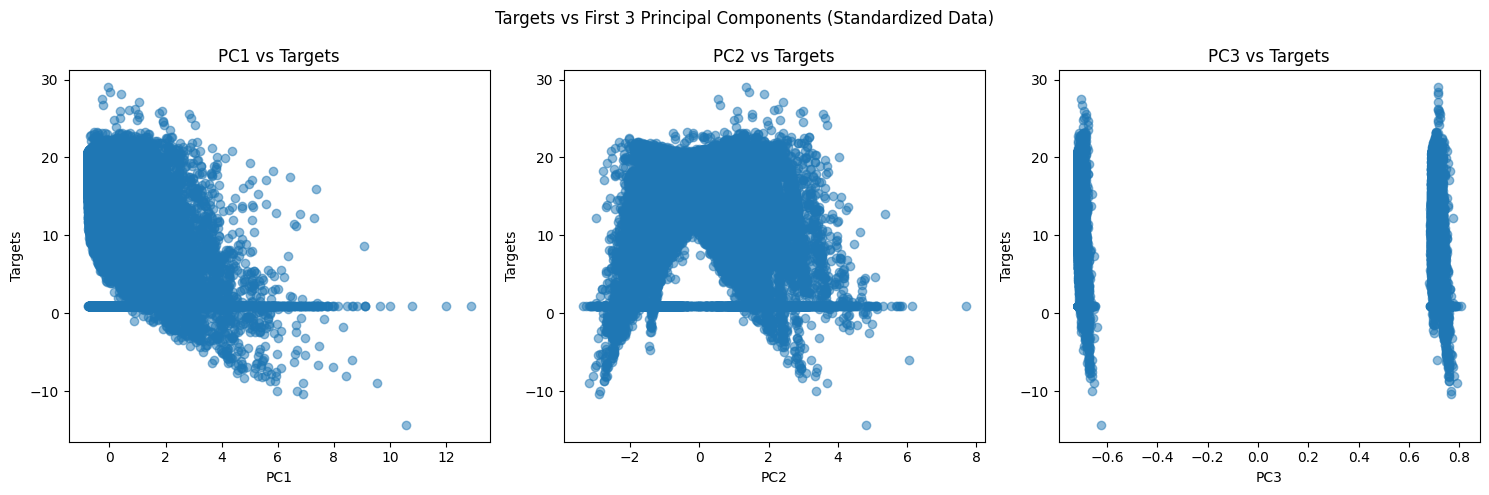

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Apply the quadratic polynomial features
current_obs_features = PolynomialFeatures(degree=2, include_bias=False).fit_transform(current_obs_input)

# Step 2: Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(current_obs_features)

# Step 3: 3D Plotting
# Step 3: Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Targets vs First 3 Principal Components (Standardized Data)')

for i in range(3):
    axs[i].scatter(pca_result[:, i], targets, alpha=0.5)
    axs[i].set_xlabel(f'PC{i+1}')
    axs[i].set_ylabel('Targets')
    axs[i].set_title(f'PC{i+1} vs Targets')

plt.tight_layout()
plt.show()


### Record a video of the trained agent

In [32]:
eval_env = gym.make(env_id, render_mode="rgb_array")
video_name = f"FQI_{env_id}_{model.__class__.__name__}.mp4"
n_eval_episodes = 3

evaluate(model, eval_env, n_eval_episodes, video_name=video_name)

/home/guillaumep/miniconda3/envs/ct-rl/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/guillaumep/ct-rl_tutorials/rlss23-dqn-tutorial-main/notebooks/logs/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Saving video to ../logs/videos/FQI_CartPole-v1_Pipeline.mp4
Total reward = 269.67 +/- 2.05


In [33]:
from dqn_tutorial.notebook_utils import show_videos

print(f"FQI agent on {env_id} after {n_iterations} iterations:")
show_videos("../logs/videos/", prefix=video_name)

FQI agent on CartPole-v1 after 20 iterations:
